In [1]:
import os 
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
data = pd.read_csv(r"E:\Yelp\Unfiltered Data\YelpZip\Customs\checkpoint")
data.head()

,index,user,item,review,rating,real,date
0,0,5044,0,drink be bad the hot chocolate be water down a...,1.0,-1,2014-11-16
1,1,5045,0,this be the bad experience ive ever have a cas...,1.0,-1,2014-09-08
2,2,5046,0,this be locate on the site of the old spruce s...,3.0,-1,2013-10-06
3,3,5047,0,i enjoy coffee and breakfast twice at toast du...,5.0,-1,2014-11-30
4,4,5048,0,i love toast the food choice be fantastic i lo...,5.0,-1,2014-08-28


In [6]:
ratings = pd.get_dummies(data['rating'])

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [4]:
# Tokenizing the data
# Max word length of each review set on 100 words
maxlen = 100
max_words = 10000

data['review'] = data['review'].apply(lambda s: str(s))

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(data['review'])
sequences = tokenizer.texts_to_sequences(data['review'])
word_index = tokenizer.word_index
print('Found %s unique tokens.'%(len(word_index)))

data = pad_sequences(sequences, maxlen=maxlen)

Found 350320 unique tokens.


In [16]:
labels = np.asarray(ratings)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (608458, 100)
Shape of label tensor: (608458, 5)


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.30, random_state=42)

NameError: name 'labels' is not defined

In [ ]:
# Preprocessing the GloVe file

embeddings_index = {}
f = open('E:/Yelp/Unfiltered Data/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.'%len(embeddings_index))

In [21]:
#Building an Embedding matrix to feed into the Embedding layer
#Must be of dimension (max_words, embedding_dim)

embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i<max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [32]:
#Defining the model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length = maxlen))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='sigmoid'))

model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['acc'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_3 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2560256   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 645       
Total para

In [33]:
#Loading pretrained word embeddings into Embedding layer and freezing their weights

model.layers[0].set_weights([embedding_matrix])
model.layers[0].traininable = False

In [34]:
#Training and evaluating the network

history = model.fit(X_train, y_train, epochs=5, batch_size=1000, validation_data=(X_test, y_test))
model.save_weights('pre_trained_glove_model.h5')

Train on 425920 samples, validate on 182538 samples
Epoch 1/5
425920/425920 [==============================] - 145s 339us/step - loss: 1.1898 - acc: 0.4596 - val_loss: 0.9774 - val_acc: 0.5561
Epoch 2/5
425920/425920 [==============================] - 141s 330us/step - loss: 0.9763 - acc: 0.5592 - val_loss: 0.9389 - val_acc: 0.5678
Epoch 3/5
425920/425920 [==============================] - 141s 330us/step - loss: 0.9128 - acc: 0.5881 - val_loss: 0.9140 - val_acc: 0.5878
Epoch 4/5
425920/425920 [==============================] - 143s 336us/step - loss: 0.8742 - acc: 0.6049 - val_loss: 0.9147 - val_acc: 0.5863
Epoch 5/5
425920/425920 [==============================] - 149s 350us/step - loss: 0.8391 - acc: 0.6203 - val_loss: 0.9223 - val_acc: 0.5832


In [36]:
#model.save(r'C:\Users\elonm\Desktop\Instant\MachineLearningProject\good_bad_model.h5')
# from keras.models import load_model
model = load_model('good_bad_model.h5')

In [42]:
y_pred = model.predict_classes(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, pd.get_dummies(y_pred)))

              precision    recall  f1-score   support

           0       0.72      0.49      0.58     10615
           1       0.43      0.31      0.36     12979
           2       0.48      0.39      0.43     24707
           3       0.53      0.70      0.60     65318
           4       0.72      0.60      0.66     68919

   micro avg       0.58      0.58      0.58    182538
   macro avg       0.57      0.50      0.53    182538
weighted avg       0.59      0.58      0.58    182538
 samples avg       0.58      0.58      0.58    182538



In [37]:
#Plotting the performance of the model

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

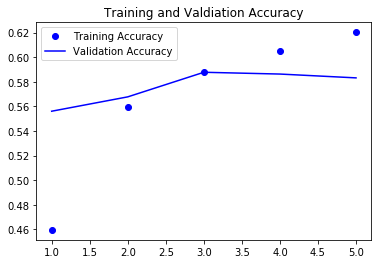

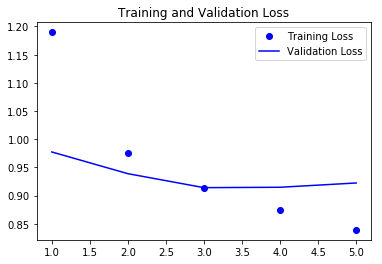

In [38]:
epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Valdiation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [ ]:
test_str = input("Enter a test string:")
test_str = test_str.lower()
tst_seq = tokenizer.texts_to_sequences([test_str])
tst_s = pad_sequences(tst_seq, maxlen=150)
tst_res = model.predict(tst_s)
print(tst_res)
print("Stars:", str(np.argmax(tst_res)+1))

In [41]:
y_pred

array([2, 1, 3, ..., 3, 4, 3], dtype=int64)